In [1]:
import duckdb
import pandas as pd
from thefuzz import fuzz
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
import numpy as np

/Users/Darren/miniconda3/envs/legislation_pipeline/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
from src.database.db_writer import Database

In [3]:
db_name = 'maine_legislation_and_testimony'
db = Database(db_name)

## Get organization names and record count

In [4]:
query = '''
    SELECT 
        Organization AS organization,
        COUNT(*) OVER (PARTITION BY Organization) AS count
    FROM TESTIMONY_HEADER th
'''

org_df = db.return_query_as_df(query)
org_df.head()

,organization,count
0,American Council of Engineering Companies of ...,1
1,"/Resident of Fryeburg, ME",1
2,04416,30
3,04416,30
4,04416,30


## Incremental comparison with string queue

In [5]:
def compute_similarity_score(string1, string2):
    token_sort_score = fuzz.token_sort_ratio(
        string1.lower(),
        string2.lower()
    )
    token_set_score = fuzz.token_set_ratio(
        string1.lower(),
        string2.lower()
    )
    return token_sort_score * 0.5 + token_set_score * 0.5

In [6]:
threshold = 0.8

# Set up string queue
queue = duckdb.query('SELECT DISTINCT ORGANIZATION FROM org_df').df().iloc[:, 0].unique().tolist()

# Iterate through queue to cluster
cluster_list = []

while len(queue) > 0:
    cluster_set = set()
    anchor_string = queue.pop(0)
    cluster_set.add(anchor_string)

    for other_string in queue:
        score = compute_similarity_score(anchor_string, other_string)
        if score >= threshold:
            cluster_set.add(other_string)
            queue.remove(other_string)

    cluster_list.append(cluster_set)

In [7]:
cluster_list

[{'Epilepsy Foundation',
  'Liberty ',
  'Carroll Harper and Associates Inc.',
  'Tri County Mental Health Services',
  'West Garrity',
  'Readsfield',
  'English Teacher',
  'Hollis Center',
  'Lone Wolf Media - South Portland',
  'Sportsmans Alliance of Maine',
  'Mike Woodard Reality',
  'Restorative Justice Project of the Midcoast',
  'J.S. McCarthy Printers',
  'Auburn Manufacturing Inc.',
  ' Portland Regional Chamber of Commerce',
  'Keller/Roller Family',
  'Scarborough Downs OTB',
  'St. Croix/Grand Lake Stream',
  'Charlie C. Soltan LLC',
  'Quimby House Inn and Spa',
  'Maine Virtual Academy',
  'New gloucester',
  'Mission Readiness',
  'East Wilton/Maine Prisoner Advocacy Coalition',
  'sUNSET',
  'Maine Families',
  'Fairfield, ME',
  'Home Care & Hospice Association',
  'Life Care Funding',
  'GDP Applied Technologies',
  'Wildlife Alliance of Maine',
  'Senior Plus',
  'Town of Carrabasset Valley',
  'Central High School',
  'Benefits Manager, City of Portland',
  'Emba

In [8]:
# model = SentenceTransformer('all-MiniLM-L6-v2')
# model.save(Path(__file__).resolve().parents[2])

KeyboardInterrupt: 

In [9]:
import os
from pathlib import Path

model_dir = str(Path(os.getcwd()).parents[1] / 'models' / 'all-minilm-l6')
# remote_model = SentenceTransformer('all-MiniLM-L6-v2')
# remote_model.save(model_dir)

In [10]:
def get_weighted_embeddings(idf, model_loc):
    # Load sentence transformer model
    model = SentenceTransformer(model_loc)

    # Generate embeddings for unique organization names
    org_names = idf['organization'].unique()
    embeddings = np.array([model.encode(name) for name in org_names])
    normalized_embeddings = normalize(embeddings, norm='l2', axis=1)

    # Create a mapping of organization names to embeddings
    name_to_embedding = dict(zip(org_names, normalized_embeddings))

    # Generate weighted embeddings based on counts
    repeated_embeddings = np.vstack([
        name_to_embedding[name] for name in idf['organization']
    ])
    return repeated_embeddings

embeddings = get_weighted_embeddings(org_df, model_dir) 
print('Generated embeddings')

Generated embeddings


In [11]:
def plot_with_pca(embedding_mat, idf):
    # Reduce embeddings to 2D using PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embedding_mat)
    
    # Visualize the clusters
    plt.figure(figsize=(10, 8))
    
    # Plot each point with color based on cluster label
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=idf['cluster'], cmap='viridis', marker='o')
    
    # Customize plot
    plt.title("PCA Projection of Organization Names Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

In [12]:
def cluster_organizations(idf, embedding_mat, eps=0.3, min_samples=2):
    """
    Cluster organization names using DBSCAN on sentence embeddings
    
    Parameters:
    df: DataFrame with columns ['organization', 'count']
    eps: DBSCAN epsilon parameter (distance threshold)
    min_samples: DBSCAN min_samples parameter
    
    Returns:
    DataFrame with original data plus cluster labels and representative names
    """
    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(embedding_mat)

    # Map DBSCAN labels back to the original dataframe
    idf['cluster'] = clustering.labels_

    cluster_representatives = {}
    for cluster_id in set(clustering.labels_):
        if cluster_id != -1:  # Skip noise points
            cluster_mask = idf['cluster'] == cluster_id
            cluster_df = idf[cluster_mask]
            representative = cluster_df.loc[cluster_df['count'].idxmax(), 'organization']
            cluster_representatives[cluster_id] = representative

    # Map cluster labels to representative names
    idf['grouped_name'] = idf['cluster'].map(cluster_representatives)
    # Fill in noise points with original org value
    idf.loc[idf['cluster'] == -1, 'grouped_name'] = idf.loc[idf['cluster'] == -1, 'organization']
    return idf

eps_test = np.linspace(0.01, 1.3, 3)
min_samples_test = np.linspace(5, 80, 3, dtype=int)
results = []
for eps in eps_test:
    for min_samples in min_samples_test:
        result = {}
        print(f'Evaluating eps: {eps} | min_samples: {min_samples}')
        result['eps'] = eps
        result['min_samples'] = min_samples
        result['df'] = cluster_organizations(org_df, embeddings, eps=eps, min_samples=min_samples)
        result['embeddings'] = embeddings
        results.append(result)

Evaluating eps: 0.01 | min_samples: 5
Evaluating eps: 0.01 | min_samples: 42
Evaluating eps: 0.01 | min_samples: 80


KeyboardInterrupt: 

In [ ]:
results[0].get('df').organization.value_counts()

Plot for 0.01


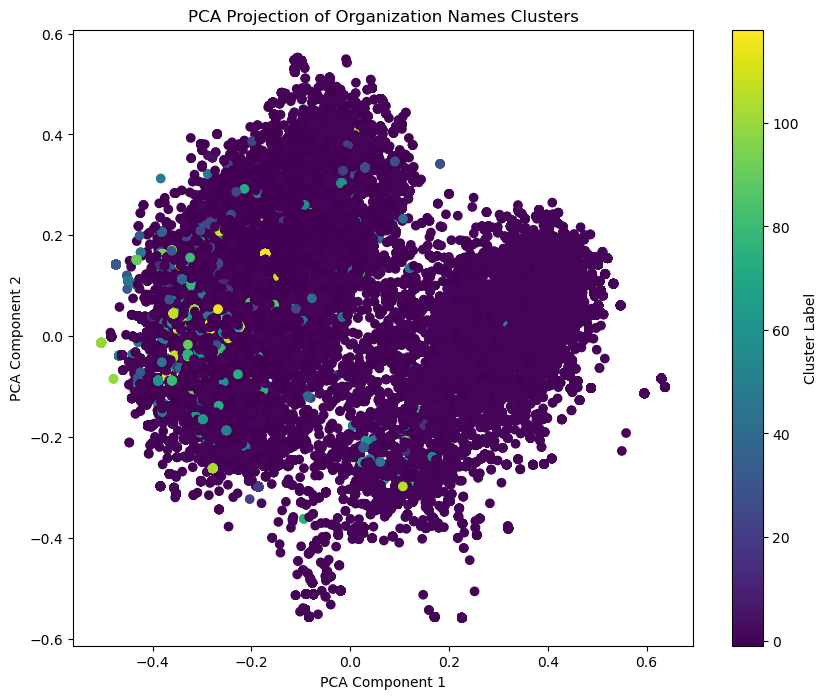

Plot for 0.155


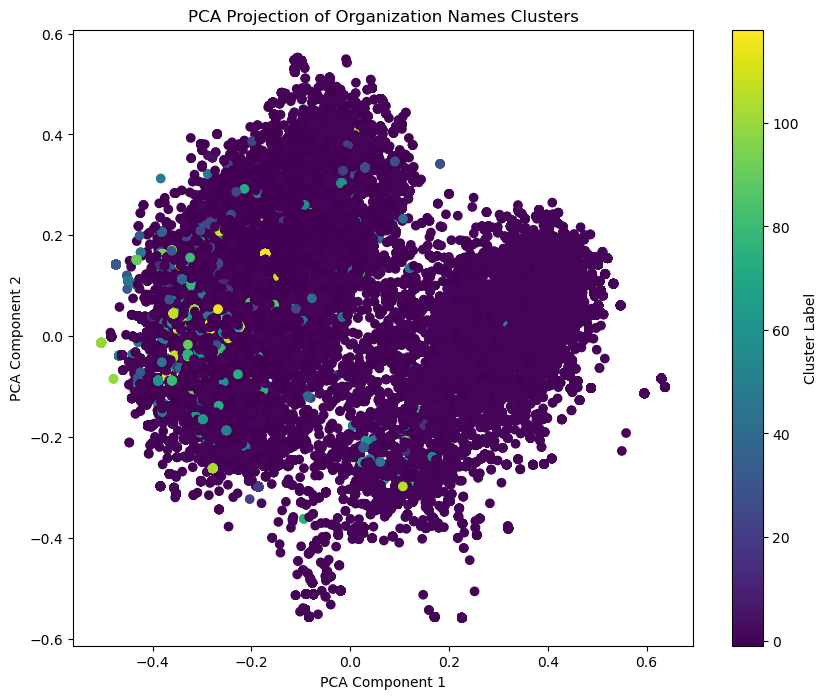

Plot for 0.3


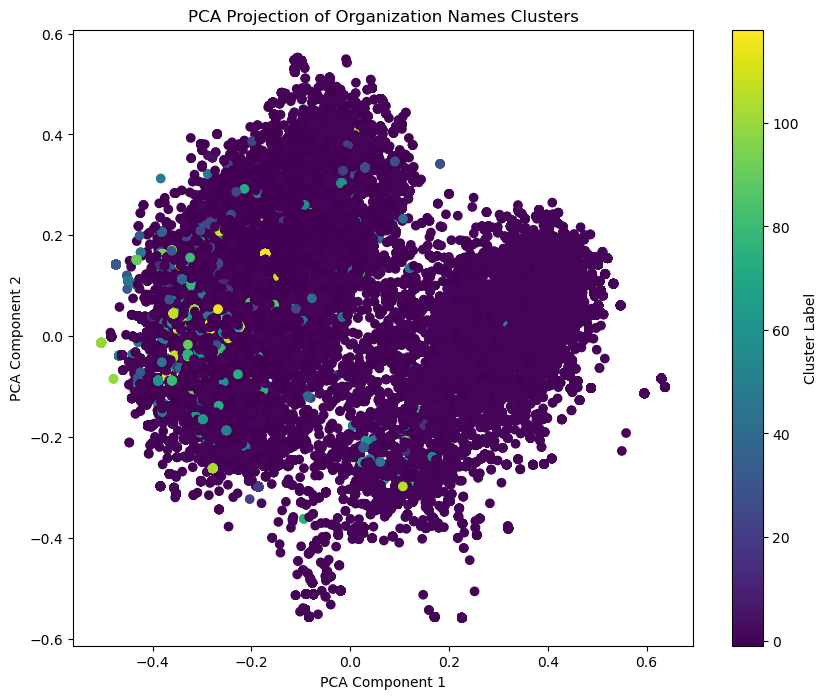

In [27]:
for result in results:
    rdf = result.get('df')
    print(f'Group count: {rdf.grouped_name.value_counts()}')
    print(f'Plot for {result.get("eps")}')
    plot_with_pca(result.get('embeddings'), result.get('df'))

In [35]:
tdf = results[0].get('df')
tdf[tdf['cluster']==59].organization.unique()

array(['Resident', 'Resident/Author', 'resident', 'Former Resident',
       'residents', 'Residents', 'Hope resident'], dtype=object)

In [28]:
query = '''
        SELECT DISTINCT * 
        FROM df 
        WHERE grouped_name = 'Maine State Legislature'
        '''

for result in results:
    eps = result.get('eps')
    df = result.get('df')
    legis_cluster = df[df['grouped_name'] == 'Maine State Legislature']
    print(f'Me Legislature group size: {len(legis_cluster)}')
    print(f'Total record size: {len(df)}')
    print(f'EPS: {eps}')
    display(legis_cluster)

Me Legislature group size: 91677
Total record size: 128437
EPS: 0.01


,organization,count,cluster,grouped_name
1,104 western ave waterville Maine 04901,1,0,Maine State Legislature
7,ACG Maine,5,0,Maine State Legislature
8,ACG Maine,5,0,Maine State Legislature
9,ACG Maine,5,0,Maine State Legislature
10,ACG Maine,5,0,Maine State Legislature
...,...,...,...,...
128430,portland,52,0,Maine State Legislature
128431,portland,52,0,Maine State Legislature
128432,portland,52,0,Maine State Legislature
128433,portland,52,0,Maine State Legislature


Me Legislature group size: 91677
Total record size: 128437
EPS: 0.155


,organization,count,cluster,grouped_name
1,104 western ave waterville Maine 04901,1,0,Maine State Legislature
7,ACG Maine,5,0,Maine State Legislature
8,ACG Maine,5,0,Maine State Legislature
9,ACG Maine,5,0,Maine State Legislature
10,ACG Maine,5,0,Maine State Legislature
...,...,...,...,...
128430,portland,52,0,Maine State Legislature
128431,portland,52,0,Maine State Legislature
128432,portland,52,0,Maine State Legislature
128433,portland,52,0,Maine State Legislature


Me Legislature group size: 91677
Total record size: 128437
EPS: 0.3


,organization,count,cluster,grouped_name
1,104 western ave waterville Maine 04901,1,0,Maine State Legislature
7,ACG Maine,5,0,Maine State Legislature
8,ACG Maine,5,0,Maine State Legislature
9,ACG Maine,5,0,Maine State Legislature
10,ACG Maine,5,0,Maine State Legislature
...,...,...,...,...
128430,portland,52,0,Maine State Legislature
128431,portland,52,0,Maine State Legislature
128432,portland,52,0,Maine State Legislature
128433,portland,52,0,Maine State Legislature


In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd

def cluster_organizations(df, eps=0.3, min_samples=2):
    """
    Cluster organization names using DBSCAN on sentence embeddings
    
    Parameters:
    df: DataFrame with columns ['organization', 'count']
    eps: DBSCAN epsilon parameter (distance threshold)
    min_samples: DBSCAN min_samples parameter
    
    Returns:
    DataFrame with original data plus cluster labels and representative names
    """
    # Load sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate embeddings for organization names
    org_frequency = df['organization'].value_counts()
    org_names = df['organization'].unique().tolist()
    name_to_embedding = {
        name: normalize(model.encode(name).reshape(1, -1), norm='l2')[0] 
        for name in org_names
    }

    weighted_embeddings = []
    for idx, row in df.iterrows():
        embedding = name_to_embedding[row['organization']]
        weighted_embeddings.extend([embedding] * row['count'])

    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(weighted_embeddings)

    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = clustering.labels_

    # For each cluster, find the organization with highest count
    cluster_representatives = {}
    for cluster_id in set(clustering.labels_):
        if cluster_id != -1:  # Skip noise points
            cluster_mask = df_clustered['cluster'] == cluster_id
            cluster_df = df_clustered[cluster_mask]
            representative = cluster_df.loc[cluster_df['count'].idxmax(), 'organization']
            cluster_representatives[cluster_id] = representative

    # Map cluster labels to representative names
    df_clustered['grouped_name'] = df_clustered['cluster'].map(cluster_representatives)
    # Keep original name for noise points (cluster = -1)
    df_clustered.loc[df_clustered['cluster'] == -1, 'grouped_name'] = \
        df_clustered.loc[df_clustered['cluster'] == -1, 'organization']

    return df_clustered

# Example usage
df = pd.DataFrame(org_df)

# clustering_df = cluster_organizations(df, eps=0.2, min_samples=50)

duckdb.query(
    '''
    SELECT DISTINCT * FROM cluster_df WHERE grouped_name = 'Maine State Legislature'
    ''').df().head(20)

/Users/Darren/miniconda3/envs/legislation_pipeline/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


NameError: name 'org_df' is not defined

In [10]:
df['organization'].repeat(df['count'])

ValueError: operands could not be broadcast together with shape (15688,) (128437,)

In [125]:
test_grid = {
    'eps': np.linspace(0, 1, 20),
    'min_samples': np.arange(2, 90, 15)
}

result = []
for eps_list, min_sample_list in (test_grid.items()):
    for eps in eps_list:
        for min_sample in min_sample_list:
            collector = {}
            collector['eps'] = eps
            collector['min_sample'] = min_sample
            result.append(collector)

result
            

[{'eps': 'e', 'min_sample': np.float64(0.0)},
 {'eps': 'e', 'min_sample': np.float64(0.05263157894736842)},
 {'eps': 'e', 'min_sample': np.float64(0.10526315789473684)},
 {'eps': 'e', 'min_sample': np.float64(0.15789473684210525)},
 {'eps': 'e', 'min_sample': np.float64(0.21052631578947367)},
 {'eps': 'e', 'min_sample': np.float64(0.2631578947368421)},
 {'eps': 'e', 'min_sample': np.float64(0.3157894736842105)},
 {'eps': 'e', 'min_sample': np.float64(0.3684210526315789)},
 {'eps': 'e', 'min_sample': np.float64(0.42105263157894735)},
 {'eps': 'e', 'min_sample': np.float64(0.47368421052631576)},
 {'eps': 'e', 'min_sample': np.float64(0.5263157894736842)},
 {'eps': 'e', 'min_sample': np.float64(0.5789473684210527)},
 {'eps': 'e', 'min_sample': np.float64(0.631578947368421)},
 {'eps': 'e', 'min_sample': np.float64(0.6842105263157894)},
 {'eps': 'e', 'min_sample': np.float64(0.7368421052631579)},
 {'eps': 'e', 'min_sample': np.float64(0.7894736842105263)},
 {'eps': 'e', 'min_sample': np.flo

In [96]:
grouping_df = duckdb.query('SELECT DISTINCT organization AS ORGANIZATION, grouped_name AS CLUSTER_LABEL FROM result').df()
grouping_df.head()

,ORGANIZATION,CLUSTER_LABEL
0,Atkinson Selectman,Atkinson Selectman
1,Backyard ADU's,Backyard ADU's
2,Beaver Cove,Beaver Cove
3,Biotechnology Innovation Organization,Biotechnology Innovation Organization
4,Blue Marble Geographics,Blue Marble Geographics


In [98]:
db.write_to_db(grouping_df, 'ORG_NAME_CLUSTERS', method='replace')

/Users/Darren/git-clones/ds5500-capstone-project/src/database/db_writer.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  with duckdb.connect(self.db_path) as conn:


## Full similarity matrix approach

In [6]:
import numpy as np

def create_similarity_matrix_numpy(names):
    n = len(names)
    # Use a numpy array to store similarity scores - more memory efficient
    score_matrix = np.zeros((n, n), dtype=np.int32)
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                score_matrix[i, j] = 100
            else:
                token_sort_score = fuzz.token_sort_ratio(
                    names[i].lower(),
                    names[j].lower()
                )
                token_set_score = fuzz.token_set_ratio(
                    names[i].lower(),
                    names[j].lower()
                )
                score = token_sort_score * 0.5 + token_set_score * 0.5
                
                # Store and mirror score to lower triangle
                score_matrix[i, j] = score
                score_matrix[j, i] = score
    
    return score_matrix

# Strings to cluster
names = org_df['ORGANIZATION'].unique()

# Get both the matrix and the lookup dictionary
similarity_matrix = create_similarity_matrix_numpy(names)

KeyboardInterrupt: 

In [7]:
threshold_matches = np.where((similarity_matrix >= 80))

In [8]:
zero_match = threshold_matches[1][threshold_matches[0] == 0]
names[zero_match]

array(['Maine State Legislature', 'Maine Legislature',
       'State of Maine Legislature', 'Maine Legislature HD73',
       'MAINE STATE LEGISLATURE', 'Maine Legislature ',
       'MMaine State Legislature', 'State Legislature',
       'Montana State Legislature', 'Legislature',
       'Maine State Legislature/Houlton Band of Maliseets',
       'Maine State Legislature, HD 53', 'Maine State Legislature '],
      dtype=object)

In [9]:
pairs = []

# Iterate over all matches
for anchor, match in zip(*threshold_matches):
    pair = (names[anchor], names[match], similarity_matrix[anchor, match])
    
    # Add to the set (automatically avoids duplicates)
    pairs.append(pair)

In [10]:
df = pd.DataFrame(pairs, columns=['ANCHOR', 'MATCH', 'SIMILARITY_SCORE'])


In [18]:
queue = list(set(threshold_matches[0]))
display(len(queue))
queue[0:10]


15688

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9)]

In [30]:
threshold_matches[0]

array([    0,     0,     0, ..., 15686, 15686, 15687])

In [37]:
zero_match = np.where(threshold_matches[0] == queue[0])
threshold_matches[1][np.isin(threshold_matches[1], zero_match)]


array([ 0,  1,  6,  2,  8,  3,  4,  5,  1,  6,  7,  2,  8,  9, 10, 11, 12,
        4,  4,  1,  0,  1,  2,  8,  1,  1,  6,  1,  6,  1,  1,  1,  1,  6,
        5,  4,  4,  3,  1,  6,  0,  7,  4,  4, 11,  5,  3,  7,  1,  6,  1,
        6, 11,  1,  6,  4,  3,  4,  1,  5,  9,  4,  1,  6,  5,  3,  6,  0,
        7, 10, 11,  1, 11, 11, 10,  3,  9,  7, 10,  2,  8,  4,  5,  1, 10,
        1,  7,  9,  1,  9,  2,  8, 11,  6,  3, 11,  1,  2,  8,  9,  3,  4,
        1,  6,  0,  4,  4,  2,  8, 11,  6,  2,  8,  1,  6,  0, 11,  7, 10,
        6,  1,  6,  3,  1,  5,  9,  1,  6,  1,  6,  6,  1,  7,  1,  6, 11,
        1,  6,  1,  7,  5,  7,  5,  1,  3,  1,  6,  3,  6,  1,  7,  1,  6,
        1,  1,  6,  3,  3,  1,  1, 11,  1,  4,  1,  1, 10,  6,  3,  7,  7,
        5,  5,  1,  6,  7,  7,  1,  1,  5,  7,  1,  1,  3,  1,  7, 10, 10,
        1,  1,  1,  2,  8,  1, 11,  2,  8,  7,  4,  5,  4,  6, 11,  4,  3,
        7,  1,  9,  0,  5,  5, 10,  6,  1,  6,  4,  3,  6,  9,  6,  6,  1,
        1,  1,  5, 11, 10

In [ ]:
cluster_list = []
cluster = set()

# Iterate over all matches
for anchor, match in zip(*threshold_matches):
    pair = clusters.add(names[anchor], names[match], similarity_matrix[anchor, match])
    
    # Add to the set (automatically avoids duplicates)
    pairs.append(pair)

/Users/Darren/git-clones/ds5500-capstone-project/src/database/db_writer.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  with duckdb.connect(self.db_path) as conn:
